## 0. 实验介绍
使用
```
-close_mean5: 5日收盘均价
-close_mean10: 10日收盘均价
-close_mean20: 20日收盘均价
```
**三个数据属性**基于**GRU**模型预测未来一个交易日的涨跌。

## 1. 数据预处理
### 1.1 根据股票代码划分数据
* 训练集

In [1]:
import pandas as pd

df = pd.read_csv("./data/train.csv", usecols=[0,1,11,12,13])
stocks_code = df["kdcode"].unique()
stock_num = len(stocks_code)

print(stocks_code)
stock_num

['000001.SZ' '000157.SZ' '000333.SZ' '000568.SZ' '000703.SZ' '000768.SZ'
 '002024.SZ' '002044.SZ' '002049.SZ' '002120.SZ' '002230.SZ' '002271.SZ'
 '002311.SZ' '002371.SZ' '002456.SZ' '002602.SZ' '002607.SZ' '002714.SZ'
 '002773.SZ' '300003.SZ' '300033.SZ' '300124.SZ' '300144.SZ' '300628.SZ'
 '600000.SH' '600009.SH' '600016.SH' '600019.SH' '600025.SH' '600028.SH'
 '600030.SH' '600031.SH' '600036.SH' '600048.SH' '600050.SH' '600061.SH'
 '600104.SH' '600115.SH' '600196.SH' '600276.SH' '600309.SH' '600340.SH'
 '600383.SH' '600489.SH' '600519.SH' '600547.SH' '600570.SH' '600585.SH'
 '600588.SH' '600690.SH' '600703.SH' '600745.SH' '600809.SH' '600837.SH'
 '600848.SH' '600886.SH' '600887.SH' '600926.SH' '600958.SH' '601006.SH'
 '601088.SH' '601166.SH' '601169.SH' '601238.SH' '601318.SH' '601319.SH'
 '601336.SH' '601398.SH' '601555.SH' '601601.SH' '601628.SH' '601788.SH'
 '601838.SH' '601857.SH' '601872.SH' '601899.SH' '601919.SH' '601990.SH'
 '601998.SH' '603233.SH' '603799.SH' '603833.SH']


82

In [2]:
# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code):
    stock_i_data = df[df['kdcode'].isin([stock_i])]
    exec("train_df%s = stock_i_data"%i)

* 测试集

In [3]:
df2 = pd.read_csv("./data/test.csv", usecols=[0,1,11,12,13])
stocks_code2 = df2["kdcode"].unique()

# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code2):
    stock_i_data = df2[df2['kdcode'].isin([stock_i])]
    exec("test_df%s = stock_i_data" % i)

共82支股票

训练集按股票分为`train_df0`~`train_df81`

测试集按股票分为`test_df0`~`test_df81`

### 1.2 将原始数据改造为LSTM网络的输入

In [4]:
feanum=3 # 一共有多少特征
window=5 # 时间窗设置

分割出window个时间窗的数据为输入的`X`

紧接着的那条数据为标签`Y`

因此需要将每只股票的数据按照时间(日期)分割成`window + 1`长度的数据

In [5]:
import numpy as np

trainResult = []
for i in range(stock_num): # 遍历训练集所有股票的DataFrame
    exec("trainData = train_df%s.values" % i)
    sequence_length = window + 1
    trainData = trainData[:,2:] # 去除股票代码、日期两字段
    for index in range(len(trainData) - sequence_length):
        trainResult.append(trainData[index: index + sequence_length])

trainResult = np.array(trainResult)
trainResult.shape

(81082, 6, 3)

In [6]:
testResult = []
for i in range(stock_num): # 遍历训练集所有股票的DataFrame
    exec("testData = test_df%s.values" % i)
    sequence_length = window + 1
    testData = testData[:,2:] # 去除股票代码、日期两字段
    for index in range(len(testData) - sequence_length):
        testResult.append(testData[index: index + sequence_length])

testResult = np.array(testResult)
testResult.shape

(19413, 6, 3)

分割`X`, `Y`

In [7]:
X_train = trainResult[:, :-1]
Y_train = trainResult[:, -1][:, -1]
X_test = testResult[:, :-1]
Y_test = testResult[:, -1][:, -1]

X_train = X_train.astype('float64')
Y_train = Y_train.astype('float64')
X_test = X_test.astype('float64')
Y_test = Y_test.astype('float64')

print("训练集X：" + str(X_train.shape))
print("训练集Y：" + str(Y_train.shape))
print("测试集X：" + str(X_test.shape))
print("测试集Y：" + str(Y_test.shape))

训练集X：(81082, 5, 3)
训练集Y：(81082,)
测试集X：(19413, 5, 3)
测试集Y：(19413,)


## 2. 模型构建与训练

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import GRU

#建立、训练模型过程
d = 0.0001
model = Sequential()#建立层次模型
model.add(GRU(64, input_shape=(window, feanum), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(GRU(16, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(Dense(4,kernel_initializer='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.fit(X_train, Y_train, epochs =100, batch_size = 256) #训练模型epochs次

Epoch 1/100
317/317 [==============================] - 2s 7ms/step - loss: 7.7075e-04 - accuracy: 1.2333e-05
Epoch 2/100
317/317 [==============================] - 2s 7ms/step - loss: 8.7655e-06 - accuracy: 2.4666e-05
Epoch 3/100
317/317 [==============================] - 2s 8ms/step - loss: 3.9176e-06 - accuracy: 2.4666e-05
Epoch 4/100
317/317 [==============================] - 2s 7ms/step - loss: 2.8350e-06 - accuracy: 2.4666e-05
Epoch 5/100
317/317 [==============================] - 2s 7ms/step - loss: 3.4039e-06 - accuracy: 2.4666e-05
Epoch 6/100
317/317 [==============================] - 2s 8ms/step - loss: 2.1112e-06 - accuracy: 2.4666e-05
Epoch 7/100
317/317 [==============================] - 2s 7ms/step - loss: 1.3498e-06 - accuracy: 2.4666e-05
Epoch 8/100
317/317 [==============================] - 2s 7ms/step - loss: 1.4429e-06 - accuracy: 2.4666e-05
Epoch 9/100
317/317 [==============================] - 2s 7ms/step - loss: 2.1230e-06 - accuracy: 2.4666e-05
Epoch 10/100
317/31

317/317 [==============================] - 2s 7ms/step - loss: 3.0449e-07 - accuracy: 2.4666e-05
Epoch 76/100
317/317 [==============================] - 2s 7ms/step - loss: 9.7745e-07 - accuracy: 2.4666e-05
Epoch 77/100
317/317 [==============================] - 2s 7ms/step - loss: 7.7835e-07 - accuracy: 2.4666e-05
Epoch 78/100
317/317 [==============================] - 2s 7ms/step - loss: 5.2389e-07 - accuracy: 2.4666e-05
Epoch 79/100
317/317 [==============================] - 2s 7ms/step - loss: 4.1724e-07 - accuracy: 2.4666e-05
Epoch 80/100
317/317 [==============================] - 2s 7ms/step - loss: 4.2152e-07 - accuracy: 2.4666e-05
Epoch 81/100
317/317 [==============================] - 2s 8ms/step - loss: 3.5530e-07 - accuracy: 2.4666e-05
Epoch 82/100
317/317 [==============================] - 2s 8ms/step - loss: 3.1617e-07 - accuracy: 2.4666e-05
Epoch 83/100
317/317 [==============================] - 2s 8ms/step - loss: 1.1207e-06 - accuracy: 2.4666e-05
Epoch 84/100
317/317 [=

In [9]:
#总结模型
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 64)             13248     
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                3936      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 17,257
Trainable params: 17,257
Non-trainable params: 0
____________________________________________________

## 3. 模型训练结果
* 训练集

In [10]:
#在训练集上的拟合结果
Y_train_predict=model.predict(X_train)[:,0]
Y_train = Y_train

Text(0.5, 1.0, 'Train Data')

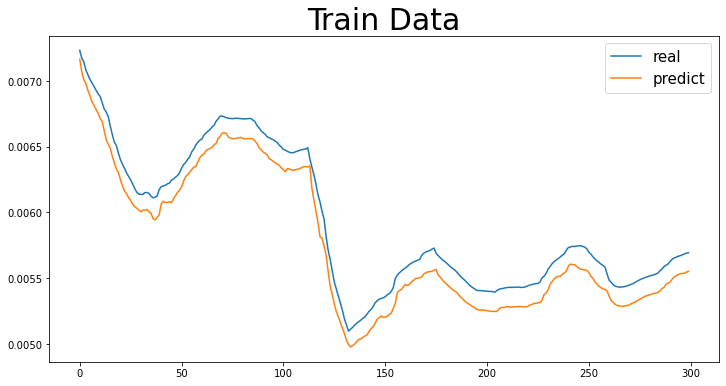

In [11]:
import matplotlib.pyplot as plt

draw=pd.concat([pd.DataFrame(Y_train),pd.DataFrame(Y_train_predict)],axis=1)
draw.iloc[:300,0].plot(figsize=(12,6))
draw.iloc[:300,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [12]:
#在测试集上的预测
Y_test_predict=model.predict(X_test)[:,0]
Y_test=Y_test

Text(0.5, 1.0, 'Test Data')

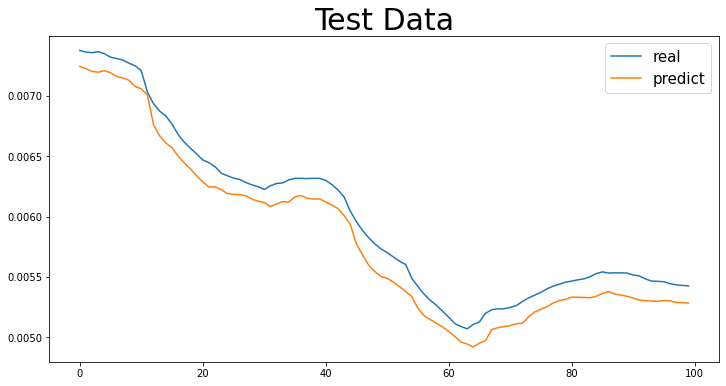

In [13]:
draw=pd.concat([pd.DataFrame(Y_test),pd.DataFrame(Y_test_predict)],axis=1);
draw.iloc[:100,0].plot(figsize=(12,6))
draw.iloc[:100,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
# 展示在测试集上的表现 

In [14]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

print('训练集上的MAE/MSE')
print(mean_absolute_error(Y_train_predict, Y_train))
print(mean_squared_error(Y_train_predict, Y_train) )

print('测试集上的MAE/MSE')
print(mean_absolute_error(Y_test_predict, Y_test))
print(mean_squared_error(Y_test_predict, Y_test) )

# 做差转换为涨跌数据
Y_var_test=Y_test[1:]-Y_test[:len(Y_test)-1]
Y_var_predict=Y_test_predict[1:]-Y_test_predict[:len(Y_test_predict)-1]

txt=np.zeros(len(Y_var_test))
for i in range(len(Y_var_test-1)):
    txt[i]=np.sign(Y_var_test[i])==np.sign(Y_var_predict[i]) # 判断符号是否相等
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)

训练集上的MAE/MSE
0.00022672787196728183
6.65749590659271e-07
测试集上的MAE/MSE
0.0002872673528061278
1.1896581801726735e-06
预测涨跌正确: 0.853389655882959


> 结果汇总

| 模型                  | window | 训练集MAE              | 训练集MSE              | 测试集MAE              | 测试集MSE              | 预测涨跌准确率     |
| --------------------- | ------ | ---------------------- | ---------------------- | ---------------------- | ---------------------- | ------------------ |
| GRU 64，16            | 5      | 0.0002171464576649033  | 2.010083395330514e-07  | 0.00023624517059636093 | 1.6650108496301442e-07 | 0.8536987430455388 |
| GRU 64，16            | 10     | 0.00012985059536376397 | 9.024482161887811e-08  | 0.00013916874461136034 | 1.1695228038641284e-07 | 0.8604883696453005 |
| GRU 64，16            | 20     | 0.00012280147113372103 | 1.355371055208561e-07  | 0.0001746643616155531  | 4.813474740677968e-07  | 0.8609613903860961 |
| GRU 80,100            | 5      | 0.00033799097251348205 | 4.6287671459664023e-07 | 0.00036944951753162356 | 7.474674783053431e-07  | 0.8381413558623532 |
| GRU 64 16 dropout=0.2 | 5      | 0.0010260594217800084  | 5.653381071789143e-06  | 0.0010979883675825987  | 7.845469936431852e-06  | 0.8172779723882134 |